In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from tensorflow.keras.utils import plot_model

import math
# import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

from tensorflow import keras
from tensorflow.keras import layers



In [2]:
df = pd.read_csv("AMD.csv")
print('Number of rows and columns:', df.shape)

Number of rows and columns: (1259, 7)


주가 데이터 출처

https://finance.yahoo.com/quote/AMD/history?p=AMD

# 데이터 살펴보기

In [3]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-02-23,14.20,14.45,13.82,14.32,14.32,80317600
1,2017-02-24,14.00,14.32,13.86,14.12,14.12,46288600
2,2017-02-27,14.27,15.35,14.27,15.20,15.20,95422900
3,2017-02-28,15.45,15.55,14.35,14.46,14.46,141783000
4,2017-03-01,15.08,15.09,14.52,14.96,14.96,73450400


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


<AxesSubplot:>

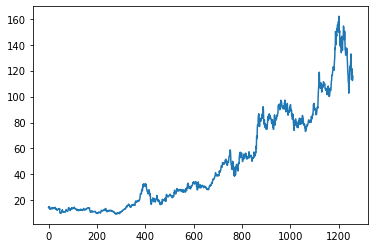

In [5]:
df['Close'].plot()

<AxesSubplot:ylabel='Close'>

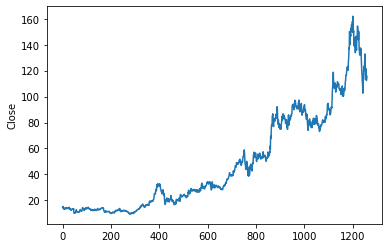

In [6]:
import seaborn as sns
sns.lineplot(data = df['Close'])

<AxesSubplot:>

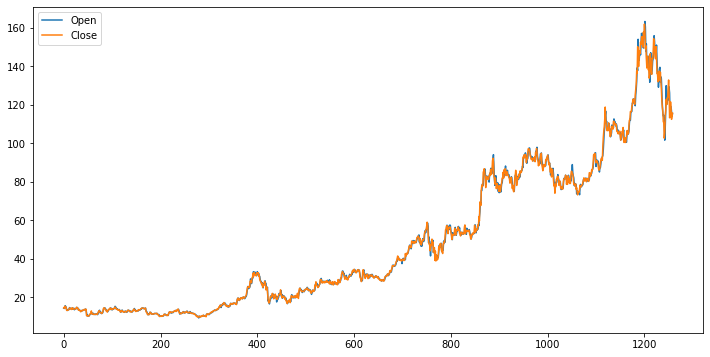

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
df['Open'].plot(ax=ax, legend=True)
df['Close'].plot(ax=ax, legend=True)

# 데이터 나누기

In [8]:
df = pd.read_csv('AMD.csv', parse_dates=True, index_col='Date')

In [9]:
test_cutoff_date = df.index.max() - timedelta(days=120) # 마지막으로부터 90일치를 test로 쓰고, 나머지는 train

df_test = df[df.index > test_cutoff_date]['Close'] # 그떄보다 크면 테스트
df_train = df[df.index <= test_cutoff_date]['Close'] # 그때보다 작으면 트레인

In [10]:
df_train.tail(3)

Date
2021-10-21    119.330002
2021-10-22    119.820000
2021-10-25    122.360001
Name: Close, dtype: float64

In [11]:
df_test.head(3)

Date
2021-10-26    122.930000
2021-10-27    122.279999
2021-10-28    121.160004
Name: Close, dtype: float64

<AxesSubplot:xlabel='Date'>

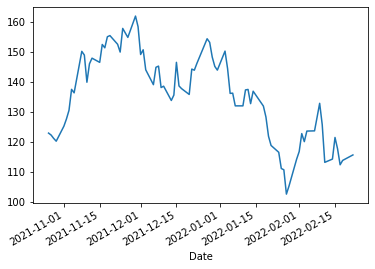

In [12]:
df_test.plot()

# 정상화 전 예측

Single Step => 1일치 예측.

## CV 데이터를 만드는 과정

In [13]:
# CV (교차검증) 데이터를 만드는 과정. 

from numpy import array

# Blocking 방법으로 교차검증 데이터를 만드는 과정.
#                  시계열,     train 시퀀스 길이=30, 예측 값의 길이=1.
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
 #    0              100
 #    1              100
	for i in range(len(sequence)): 
		end_ix = i + n_steps_in # train 시퀀스의 끝 index를 계산.
		out_end_ix = end_ix + n_steps_out # 예측 시퀀스의 끝 index 계산.
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x) # 0,30 / 1,31 / 2,32 ...... 69 / 99
		y.append(seq_y) # 31 / 32 / 33 ..........  100
	return array(X), array(y)

raw_seq = df_train # train seq를 block cv가 가능하도록 쪼갠다.
n_steps_in = 30 # 60일치를 보고
n_steps_out = 1 # 1일을 맞추는 코드.

X, y = split_sequence(raw_seq, n_steps_in, n_steps_out) # 데이터 분할

n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [14]:
X.shape # 우리의 피처는 30일치씩 1147여개

(1147, 30, 1)

In [15]:
y.shape

(1147, 1)

## 모델만들기

In [16]:
# Model을 만들기 시작하는 부분

from keras.models import Sequential, Input # 케라스는 일반적으로 시퀀셜.
from keras.layers import LSTM, Dropout, SimpleRNN, GRU
from keras.layers import Dense # NN

In [17]:
model = Sequential() # 순차적 모델.
              # NN의 차원 => 32개의 히든 레이어
# model.add(layer)
              # 차원의 갯수 = 히든레이어 갯수.
model.add(LSTM(128, activation='relu',  # Many To one
                            # n_steps_in=30, n_features = 1
               input_shape=(n_steps_in, n_features), return_sequences=False)) # return_sequences default = False로 하면 단층 LSTM구조가 된다.
               
# model.add(Dropout(0.5))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
#               # NN 차원 = 128개의 히든레이어
# model.add(LSTM(128, activation='relu')) # Many to One

# 마지막 레이어 128개의 벡터값을 하나로 만든다.
model.add(Dense(1)) # Dense = 바닐라 NN

# 모델이 학습할 방법을 지정해준다.
#              Gradiant 계산 방법, loss 함수 ?Mean Absolute Error
#                                loss = mae, mse = Mean Squared Error => 오차가 큰 경우에 패널티가 커짐.
model.compile(optimizer='adam', loss='mse') # 컴파일 과정

module 'tensorflow.python.framework.ops' has no attribute '_TensorLike' 오류로

pip uninstall keras && pip install keras==2.4.3

터미널에서 하기 ㅠㅠ

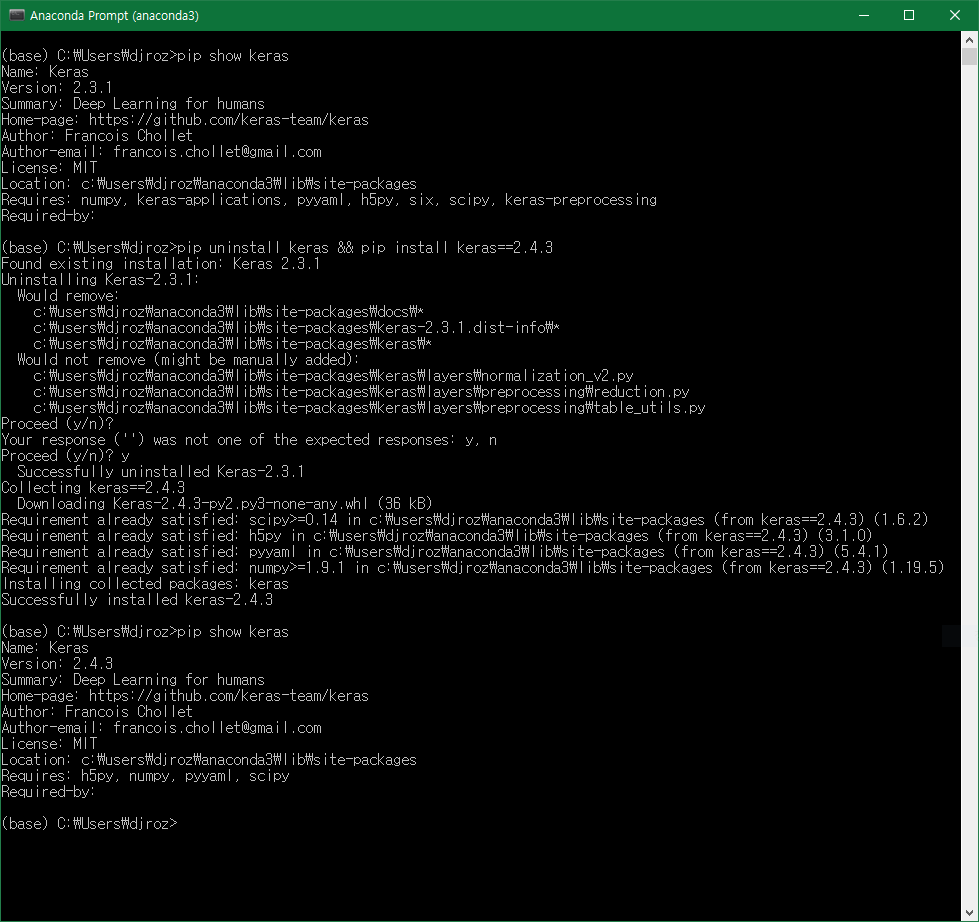

---

다시 깔으니 된다!

In [18]:
# # Feature Scaling (인터넷에서 데려온 코드분...)

# sc = MinMaxScaler(feature_range = (0, 1))

# training_set_scaled = sc.fit_transform(df_train)

# # Creating a data structure with 60 time-steps and 1 output

# X_train = []
# y_train = []

# for i in range(60, 800):
#     X_train.append(training_set_scaled[i-60:i, 0])
#     y_train.append(training_set_scaled[i, 0])

# X_train, y_train = np.array(X_train), np.array(y_train)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# #(740, 60, 1)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [21]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


오케이 다시 깔고올게...

pip install pydot

pip install graphviz

---

안되네 ㅎㅎ 그냥 진행

### 학습

In [22]:
history = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
18/18 [==============================] - 4s 65ms/step - loss: 1068.6417
Epoch 2/100
18/18 [==============================] - 1s 64ms/step - loss: 213.8548
Epoch 3/100
18/18 [==============================] - 1s 68ms/step - loss: 115.6810
Epoch 4/100
18/18 [==============================] - 1s 74ms/step - loss: 58.3769
Epoch 5/100
18/18 [==============================] - 1s 70ms/step - loss: 32.7642
Epoch 6/100
18/18 [==============================] - 1s 80ms/step - loss: 28.9507
Epoch 7/100
18/18 [==============================] - 1s 77ms/step - loss: 25.9857
Epoch 8/100
18/18 [==============================] - 1s 69ms/step - loss: 26.4821
Epoch 9/100
18/18 [==============================] - 1s 57ms/step - loss: 22.9106
Epoch 10/100
18/18 [==============================] - 1s 70ms/step - loss: 25.5108
Epoch 11/100
18/18 [==============================] - 1s 48ms/step - loss: 18.7149
Epoch 12/100
18/18 [==============================] - 1s 40ms/step - loss: 15.3795
Epoch 13/

18/18 [==============================] - 1s 58ms/step - loss: 3.7148


### 예측

In [23]:
train_pred = model.predict(X)

In [24]:
train_pred.shape

(1147, 1)

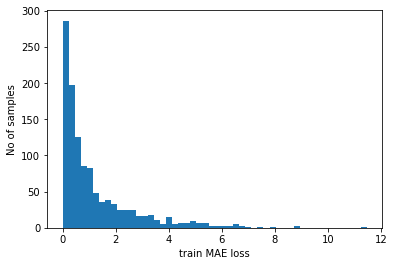

In [25]:
                                # 전체 데이터에 대해서 예측값 - 실제값
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss") # 절대오차 (여기 그래프에서의 3000이 넘어가는 값)
plt.ylabel("No of samples")
plt.show()

오차가 중간에 좀 줄었다 늘었다 하기도 한다. 

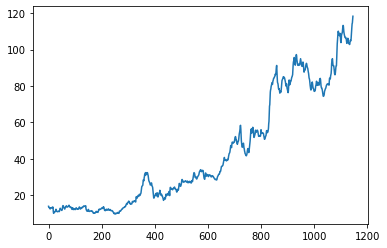

In [26]:
plt.plot(train_pred)

In [38]:
train_pred

array([[ 13.888541],
       [ 13.268168],
       [ 13.29093 ],
       ...,
       [114.611015],
       [116.60284 ],
       [118.324104]], dtype=float32)

In [34]:
df_train

Date
2017-02-23     14.320000
2017-02-24     14.120000
2017-02-27     15.200000
2017-02-28     14.460000
2017-03-01     14.960000
                 ...    
2021-10-19    116.330002
2021-10-20    116.389999
2021-10-21    119.330002
2021-10-22    119.820000
2021-10-25    122.360001
Name: Close, Length: 1177, dtype: float64

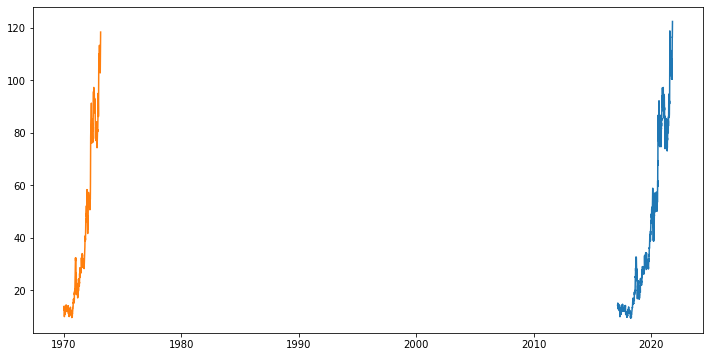

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(df_train)
plt.plot(train_pred)

ㅋㅋㅋㅋㅋ 왜 트레인 데이터 날짜왜이러니 ㅎㅎ

 수업 노트
 
 ---
 
 실제값이 예측값을 반복시킨 상황이다. 예측값을 그냥 딜레이 시킨것. 정확히 30일 뒤로 늦춘 상황인 것이다.

패턴을 못찾으니까 그냥 그대로 딜레이 시킨 것이다.

close

이것을 lagging. 예측값이 실측값ㄱ보다 래깅되어있다.

생각보다 많이 일어난다 (LSTM같은 모델을 썼을 때)

케라스

이것이 DRNN 을 하는 과정이다.

마지막 리턴시퀀스가 FALSE 가 되어야 한다.

## DRNN 진행

In [47]:
model = Sequential() # 순차적 모델.
              # NN의 차원 => 32개의 히든 레이어
# model.add(layer)
              # 차원의 갯수 = 히든레이어 갯수.
model.add(LSTM(256, activation='relu',  # Many To Many
                            # n_steps_in=30, n_features = 1
               input_shape=(n_steps_in, n_features), return_sequences=True)) # return_sequences default = False로 하면 단층 LSTM구조가 된다.

model.add(Dropout(0.5))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, activation='relu', return_sequences=True))
model.add(Dropout(0.5))
              # NN 차원 = 128개의 히든레이어
model.add(LSTM(256, activation='relu', return_sequences=False)) # Many to One
model.add(Dense(1)) # Dense = 바닐라 NN

# 모델이 학습할 방법을 지정해준다.
#              Gradiant 계산 방법, loss 함수 ?Mean Absolute Error
#                                loss = mae, mse = Mean Squared Error => 오차가 큰 경우에 패널티가 커짐.
model.compile(optimizer='adam', loss='mse')

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 256)           264192    
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 30, 256)           525312    
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 256)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)              

In [49]:
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


아맞다

In [50]:
history = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
18/18 [==============================] - 17s 685ms/step - loss: 1182.1626
Epoch 2/100
18/18 [==============================] - 12s 675ms/step - loss: 3056.2820
Epoch 3/100
18/18 [==============================] - 12s 691ms/step - loss: 781422.9375
Epoch 4/100
18/18 [==============================] - 13s 711ms/step - loss: 4768478208.0000
Epoch 5/100
18/18 [==============================] - 13s 741ms/step - loss: 9093475328.0000
Epoch 6/100
18/18 [==============================] - 13s 724ms/step - loss: 1551653248.0000
Epoch 7/100
18/18 [==============================] - 13s 718ms/step - loss: 6164601.0000
Epoch 8/100
18/18 [==============================] - 13s 737ms/step - loss: 1557728.3750
Epoch 9/100
18/18 [==============================] - 12s 658ms/step - loss: 2006135.0000
Epoch 10/100
18/18 [==============================] - 12s 660ms/step - loss: 2709543.5000
Epoch 11/100
18/18 [==============================] - 13s 727ms/step - loss: 3678424.2500
Epoch 12/100
18/1

KeyboardInterrupt: 

기하급수적으로 오래걸리는데..?

1024를 256으로 바꾸어보았다.


loss가 6자리씩 되는데 이게 맞습니까?

틀려먹은것 같은데 심지어 많이 줄어들지도 않는다.  63회에서 중단시킨 결과

---

Epoch 61/100

18/18 [==============================] - 13s 732ms/step - loss: 366626.5938

Epoch 62/100

18/18 [==============================] - 14s 800ms/step - loss: 459398.6250

Epoch 63/100

 2/18 [==>...........................] - ETA: 10s - loss: 407829.1250

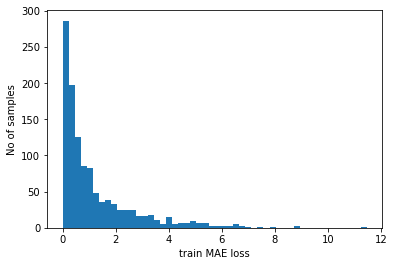

In [53]:
                                # 전체 데이터에 대해서 예측값 - 실제값
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss") # 절대오차 (여기 그래프에서의 3000이 넘어가는 값)
plt.ylabel("No of samples")
plt.show()

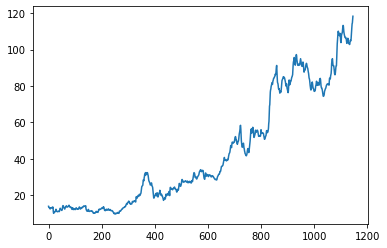

In [54]:
plt.plot(train_pred)

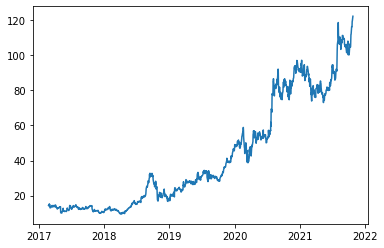

In [55]:
plt.plot(df_train)

In [56]:
train_df_with_pred = df_train.to_frame()[n_steps_in:]
train_df_with_pred['pred'] = train_pred

<AxesSubplot:xlabel='Date'>

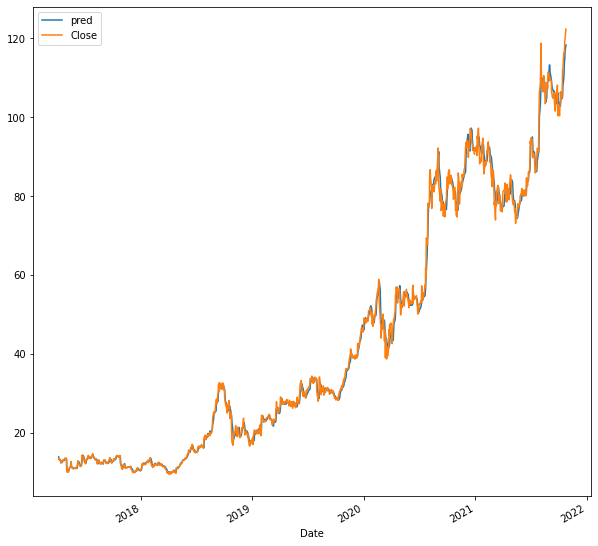

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
train_df_with_pred['pred'].plot(ax=ax, legend=True)
train_df_with_pred['Close'].plot(ax=ax, legend=True)

# test 진행

In [58]:
test_raw_seq = df_test

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [59]:
y_pred = model.predict(test_X)

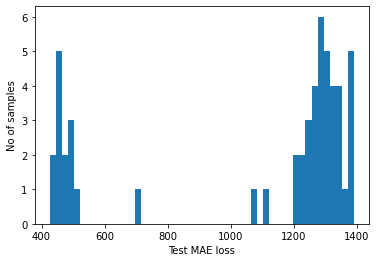

In [60]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

오차가...ㅎㅎ 적지는 않은것같은데

In [61]:
test_df_with_pred = df_test.to_frame()[n_steps_in:]
test_df_with_pred['pred'] = y_pred

<AxesSubplot:xlabel='Date'>

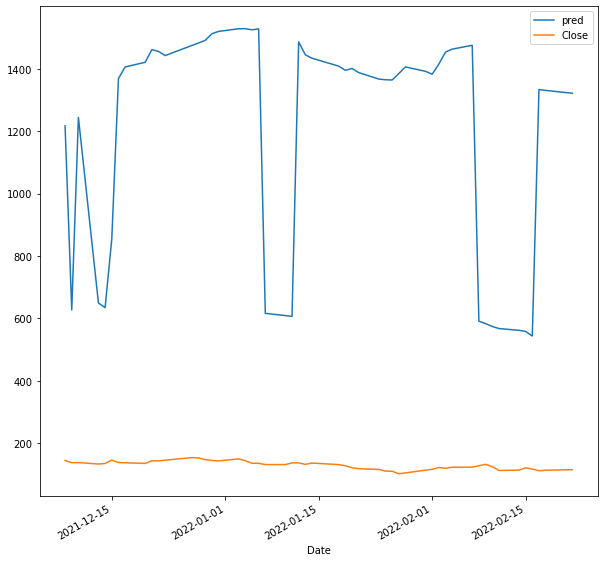

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
test_df_with_pred['pred'].plot(ax=ax, legend=True)
test_df_with_pred['Close'].plot(ax=ax, legend=True)

In [64]:
??

In [ ]:
미쳤나요?

# 다시, DRNN말고 RNN(LSTM)으로 해보자

In [65]:
model = Sequential() # 순차적 모델.
              # NN의 차원 => 32개의 히든 레이어
# model.add(layer)
              # 차원의 갯수 = 히든레이어 갯수.
model.add(LSTM(128, activation='relu',  # Many To one
                            # n_steps_in=30, n_features = 1
               input_shape=(n_steps_in, n_features), return_sequences=False)) # return_sequences default = False로 하면 단층 LSTM구조가 된다.
               
# model.add(Dropout(0.5))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
#               # NN 차원 = 128개의 히든레이어
# model.add(LSTM(128, activation='relu')) # Many to One

# 마지막 레이어 128개의 벡터값을 하나로 만든다.
model.add(Dense(1)) # Dense = 바닐라 NN

# 모델이 학습할 방법을 지정해준다.
#              Gradiant 계산 방법, loss 함수 ?Mean Absolute Error
#                                loss = mae, mse = Mean Squared Error => 오차가 큰 경우에 패널티가 커짐.
model.compile(optimizer='adam', loss='mse') # 컴파일 과정

In [66]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


### 학습

In [67]:
history = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
18/18 [==============================] - 1s 29ms/step - loss: 1080.8021
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 13.1264
Epoch 3/100
18/18 [==============================] - 1s 30ms/step - loss: 6.9615
Epoch 4/100
18/18 [==============================] - 1s 49ms/step - loss: 5.3394
Epoch 5/100
18/18 [==============================] - 1s 43ms/step - loss: 4.8603
Epoch 6/100
18/18 [==============================] - 1s 49ms/step - loss: 3.9036
Epoch 7/100
18/18 [==============================] - 1s 48ms/step - loss: 3.5244
Epoch 8/100
18/18 [==============================] - 1s 45ms/step - loss: 3.5609
Epoch 9/100
18/18 [==============================] - 1s 43ms/step - loss: 3.6861
Epoch 10/100
18/18 [==============================] - 1s 48ms/step - loss: 3.6744
Epoch 11/100
18/18 [==============================] - 1s 64ms/step - loss: 3.7130: 0s - loss - ETA: 0s - loss: 3.81
Epoch 12/100
18/18 [==============================] - 1s 76ms/step - 

18/18 [==============================] - 1s 44ms/step - loss: 3.0394


### 예측

In [68]:
train_pred = model.predict(X)

In [69]:
train_pred.shape

(1147, 1)

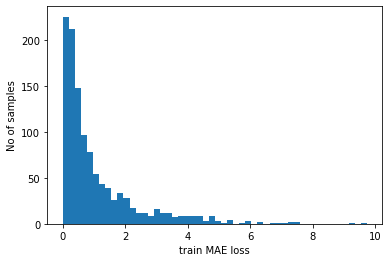

In [70]:
                                # 전체 데이터에 대해서 예측값 - 실제값
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss") # 절대오차 (여기 그래프에서의 3000이 넘어가는 값)
plt.ylabel("No of samples")
plt.show()

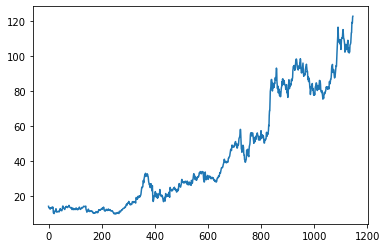

In [71]:
plt.plot(train_pred)

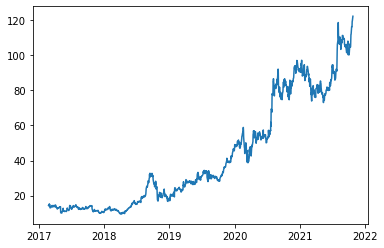

In [72]:
plt.plot(df_train)

In [73]:
train_df_with_pred = df_train.to_frame()[n_steps_in:]
train_df_with_pred['pred'] = train_pred

<AxesSubplot:xlabel='Date'>

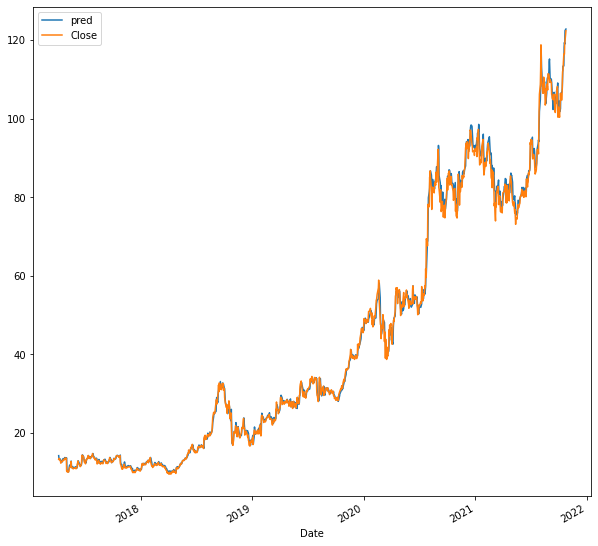

In [74]:
fig, ax = plt.subplots(figsize=(10,10))
train_df_with_pred['pred'].plot(ax=ax, legend=True)
train_df_with_pred['Close'].plot(ax=ax, legend=True)

# 다시 test

In [75]:
test_raw_seq = df_test

test_X, test_y = split_sequence(test_raw_seq, n_steps_in, n_steps_out)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [76]:
y_pred = model.predict(test_X)

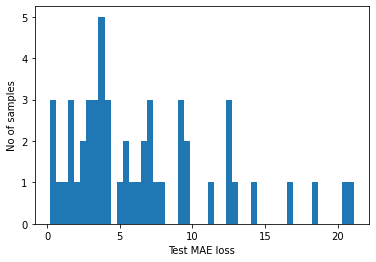

In [77]:
test_mae_loss = np.mean(np.abs(y_pred - test_y), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

오차가...ㅎㅎ 적지는 않은것같은데

In [78]:
test_df_with_pred = df_test.to_frame()[n_steps_in:]
test_df_with_pred['pred'] = y_pred

<AxesSubplot:xlabel='Date'>

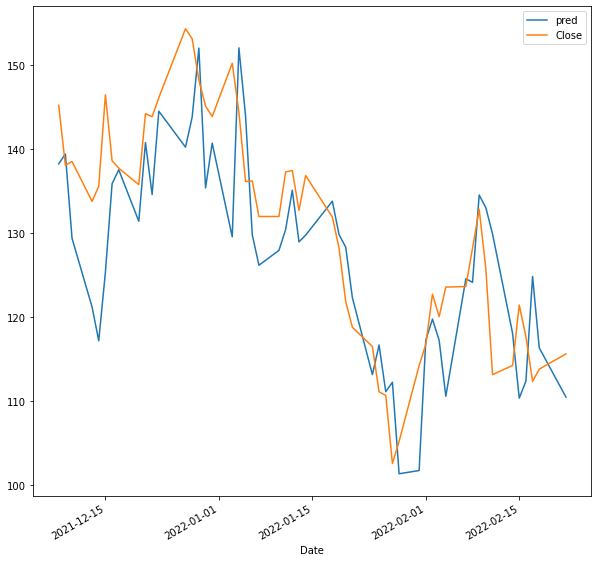

In [79]:
fig, ax = plt.subplots(figsize=(10,10))
test_df_with_pred['pred'].plot(ax=ax, legend=True)
test_df_with_pred['Close'].plot(ax=ax, legend=True)

심각하게 못맞추네요? 대체적인 경향성은 좀 맞춘거같긴 한데

예측값과 실제값이 정말.. 큰 상황이네요? ㅎㅎ

In [81]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequence):
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# Multi step

In [83]:
raw_seq = df_train

n_steps_in, n_steps_out = 60, 7
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [84]:
y

array([[ 11.41    ,  11.04    ,  10.89    , ...,  10.98    ,  11.      ,
         11.12    ],
       [ 11.04    ,  10.89    ,  10.89    , ...,  11.      ,  11.12    ,
         11.19    ],
       [ 10.89    ,  10.89    ,  10.98    , ...,  11.12    ,  11.19    ,
         10.93    ],
       ...,
       [109.160004, 111.989998, 112.120003, ..., 116.330002, 116.389999,
        119.330002],
       [111.989998, 112.120003, 116.43    , ..., 116.389999, 119.330002,
        119.82    ],
       [112.120003, 116.43    , 116.330002, ..., 119.330002, 119.82    ,
        122.360001]])

return_sequences default = False로 하면 단층 LSTM구조가 된다.

return_sequences default = False로 하면 단층 LSTM구조가 된다.

In [86]:
model = Sequential()
model.add(LSTM(128, activation='relu', 
              #  return_sequences=True, 
               input_shape=(n_steps_in, n_features))) 
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu', return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(1024, activation='relu'))
# 출력 시계열의 특징이 있다면, 모델링 하는 코드가 들어가야 함.
# 없으면 그냥 쓰면 됨.
model.add(Dense(n_steps_out)) # 7
model.compile(optimizer='adam', loss='mae')

Dense는 나오는 대로 받아서 만드는 

In [87]:
history = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
18/18 [==============================] - 2s 73ms/step - loss: 207.5333
Epoch 2/100
18/18 [==============================] - 2s 95ms/step - loss: 741.5416
Epoch 3/100
18/18 [==============================] - 2s 95ms/step - loss: 49.2866
Epoch 4/100
18/18 [==============================] - 2s 94ms/step - loss: 43.0442
Epoch 5/100
18/18 [==============================] - 2s 91ms/step - loss: 41.2588
Epoch 6/100
18/18 [==============================] - 2s 93ms/step - loss: 37.8595
Epoch 7/100
18/18 [==============================] - 2s 97ms/step - loss: 34.8186
Epoch 8/100
18/18 [==============================] - 2s 98ms/step - loss: 32.6327
Epoch 9/100
18/18 [==============================] - 2s 106ms/step - loss: 30.3464
Epoch 10/100
18/18 [==============================] - 2s 107ms/step - loss: 28.7191
Epoch 11/100
18/18 [==============================] - 2s 101ms/step - loss: 26.5798
Epoch 12/100
18/18 [==============================] - 2s 105ms/step - loss: 24.9945
Epoch 1

18/18 [==============================] - 2s 96ms/step - loss: 6.5415
Epoch 100/100
18/18 [==============================] - 2s 95ms/step - loss: 6.4977


In [88]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dense_6 (Dense)              (None, 7)                 903       
Total params: 67,463
Trainable params: 67,463
Non-trainable params: 0
_________________________________________________________________


In [89]:
 #                 X=입력, y=라벨, epochs=반복수, batch_size = 한번에 병렬학습 시키는 개수
history = model.fit(X, y, epochs=100, batch_size=64)

Epoch 1/100
18/18 [==============================] - 2s 98ms/step - loss: 6.4739
Epoch 2/100
18/18 [==============================] - 2s 103ms/step - loss: 6.4689 0s - loss:
Epoch 3/100
18/18 [==============================] - 2s 109ms/step - loss: 6.3350
Epoch 4/100
18/18 [==============================] - 2s 114ms/step - loss: 6.4032
Epoch 5/100
18/18 [==============================] - 2s 97ms/step - loss: 6.3041
Epoch 6/100
18/18 [==============================] - 2s 98ms/step - loss: 6.3104
Epoch 7/100
18/18 [==============================] - 2s 92ms/step - loss: 6.3400
Epoch 8/100
18/18 [==============================] - 2s 94ms/step - loss: 6.3301
Epoch 9/100
18/18 [==============================] - 2s 92ms/step - loss: 6.1974
Epoch 10/100
18/18 [==============================] - 2s 96ms/step - loss: 6.1808
Epoch 11/100
18/18 [==============================] - 2s 91ms/step - loss: 6.1275
Epoch 12/100
18/18 [==============================] - 2s 94ms/step - loss: 6.1189
Epoch 13/10

KeyboardInterrupt: 

어라라 왜 또돌려요? ㅋㅋㅋㅋㅋㅋ

그만하죠

## test

In [90]:
# train을 그대로 다시 예측.
train_pred = model.predict(X)

In [91]:
train_pred.shape

(1111, 7)

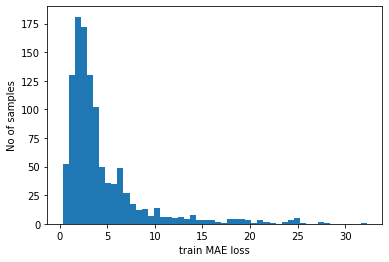

In [92]:
                                # 전체 데이터에 대해서 예측값 - 실제값
train_mae_loss = np.mean(np.abs(train_pred - y), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("train MAE loss") # 절대오차 (여기 그래프에서의 3000이 넘어가는 값)
plt.ylabel("No of samples")
plt.show()

여전히 좀 구리네요

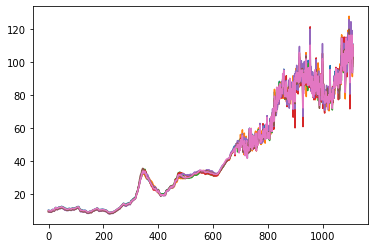

In [93]:
plt.plot(train_pred)

아까 덴스가 받은대로 넣기 때문에 7개가 나왔다.

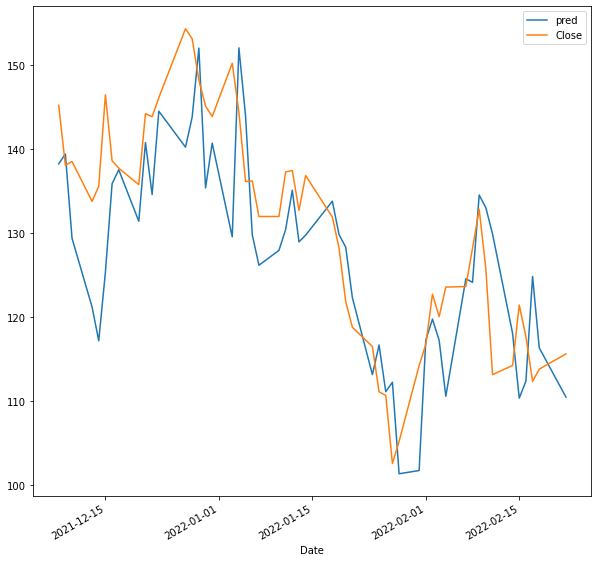

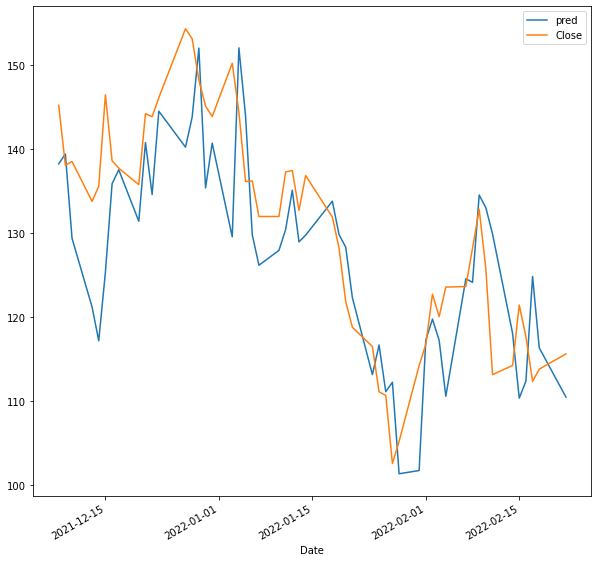

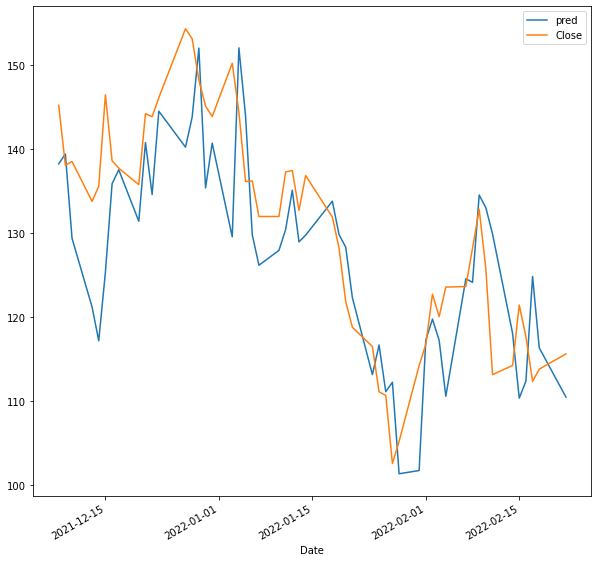

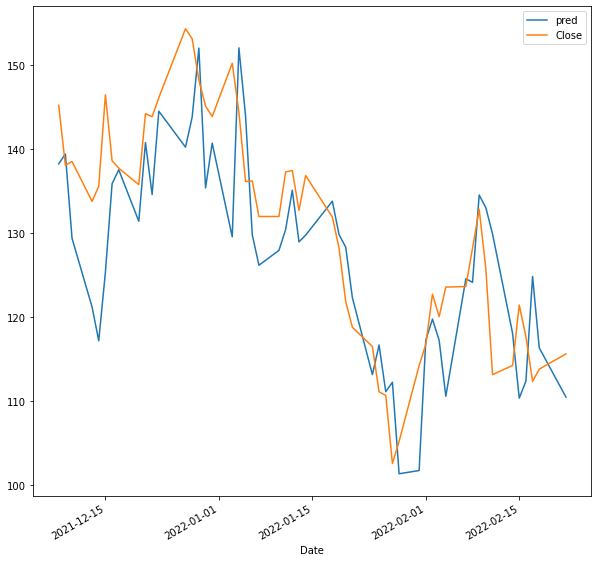

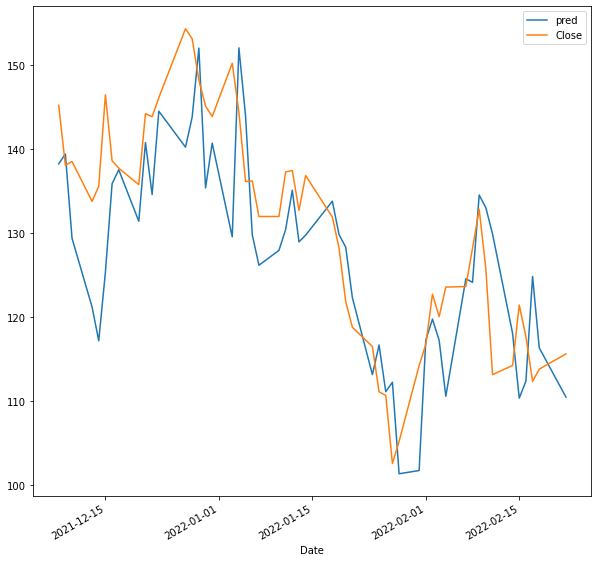

In [94]:
for i, pred in enumerate(train_pred[:5]):
    train_df_with_pred = df_train[i:i+n_steps_out]
    train_df_with_pred['pred'] = pred
    fig, ax = plt.subplots(figsize=(10,10))
    test_df_with_pred['pred'].plot(ax=ax, legend=True)
    test_df_with_pred['Close'].plot(ax=ax, legend=True)
    plt.show()

오 제법 구려요

결론 :  CNN 공부로 넘어갑시다